In [1]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt

import math, time
import itertools
import datetime
from operator import itemgetter
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


import pandas as pd
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import Series

from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers import LSTM, TimeDistributed


Using TensorFlow backend.


## Load the stock data

### Choose CSV file of the company stock price

In [2]:
! ls

AAPL.csv		      NFLX.csv
AMZN.csv		      __pycache__
assessment_dsml1_train.csv    stock_LSTM-Copy1.ipynb
click_pred.ipynb	      stock_LSTM.ipynb
DSML1 - 4 - Assessment.ipynb  stock_LSTM-modular.ipynb
FB.csv			      Stock_LSTM_n.ipynb
FBdata.csv		      stock_modular.ipynb
fb.ipynb		      Stock-Predictor-using-LSTM.ipynb
files			      Stock_prices_m.zip
GOOG.csv		      Test.ipynb
lstm.py			      TSLA.csv
model.h5		      TSLAdata.csv
model.json		      Untitled.ipynb


In [3]:
import os
path =r'/mapr_data/auro_157072/business_news/news_02/Stock/Stock/files'

os.chdir(path)
arr = os.listdir()
arr

['Apple.csv', 'Amazon.csv', 'Facebook.csv']

In [4]:
import glob

#path =r'/mapr_data/auro_157072/business_news/news_02/Stock/Files'
filenames = glob.glob(path + "/*.csv")

In [5]:
glob.glob(path +"/*.csv")

['/mapr_data/auro_157072/business_news/news_02/Stock/Stock/files/Apple.csv',
 '/mapr_data/auro_157072/business_news/news_02/Stock/Stock/files/Amazon.csv',
 '/mapr_data/auro_157072/business_news/news_02/Stock/Stock/files/Facebook.csv']

In [6]:
arr[0][:-4]

'Apple'

In [7]:
dfs = []
for index,filename in enumerate(filenames):
    df = pd.read_csv(filename)
    
    close_name = 'Close_' + arr[index][:-4]
    col_names = ['Timestamp','Sequence','Open','High','Low',close_name,'Volume']
    df.columns = col_names
    df['Timestamp'] =  pd.to_datetime(df['Timestamp'],format='%Y-%m-%d %H:%M:%S')
    df.index = df['Timestamp']
    df = df.drop(['Sequence','Timestamp'],axis =1)
    
    df = df[[close_name]]
    df = df.loc['2018-03-14']
    
    dfs.append(df)

In [8]:
len(dfs)

3

In [9]:
arr

['Apple.csv', 'Amazon.csv', 'Facebook.csv']

In [10]:
result = pd.concat(dfs, axis=1)
result.shape

(391, 3)

In [11]:
result.head(1)

,Close_Apple,Close_Amazon,Close_Facebook
Timestamp,,,
2018-03-14 13:30:00,180.32,1597.0,182.6


In [12]:
result.iloc[:, [2]].plot()

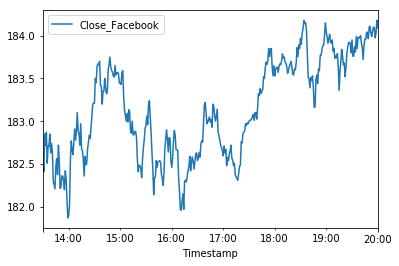

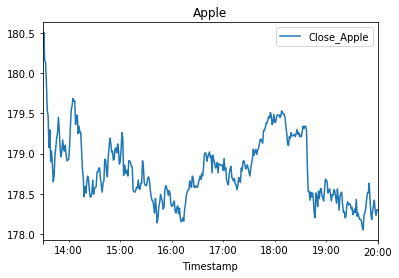

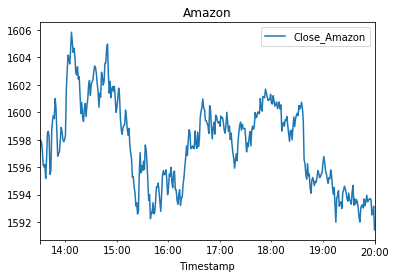

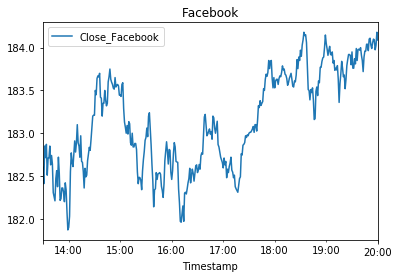

In [13]:
plt.figure(figsize=(15,8))

for i in range(len(dfs)):
    #plt.subplot(i,1,1)
    result.iloc[:, [i]].plot()
    plt.title(arr[i][:-4])


plt.legend()
plt.show()

In [14]:
train_data =result.iloc[:-50]
train_data.shape

(341, 3)

In [15]:
test_data = result.iloc[-50:]
test_data.shape

(50, 3)

In [16]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [17]:
result.iloc[:, [2]].head()

,Close_Facebook
Timestamp,
2018-03-14 13:30:00,182.6000
2018-03-14 13:31:00,182.4100
2018-03-14 13:32:00,182.8500
2018-03-14 13:33:00,182.7149
2018-03-14 13:34:00,182.8700


In [18]:
trains,train_scaleds,tests,test_scaleds  = [],[],[],[]

for i in range(len(dfs)):
    series = result.iloc[:, [i]]
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    supervised = timeseries_to_supervised(diff_values, 4)
    supervised_values = supervised.values
    train, test = supervised_values[0:-100], supervised_values[-100:]
    
    trains.append(train)
    tests.append(test)
    
    scaler, train_scaled, test_scaled = scale(train, test)
    train_scaleds.append(train_scaled)
    test_scaleds.append(test_scaled)

/mapr_data/dev_repo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [19]:
merge_train = np.insert(trains[0][:,:-1],[4],trains[1][:,:-1], axis=1)
merge_test = np.insert(tests[0][:,:-1],[4],tests[1][:,:-1], axis=1)

for i in range(len(dfs)-2):
    merge_train = np.insert(merge_train,[4 * (i+2)],trains[i+2][:,:-1], axis=1)
    merge_test  = np.insert(merge_test,[4 * (i+2)],tests[i+2][:,:-1], axis=1)
    

In [20]:
print(merge_train.shape)
print(merge_test.shape)

(290, 12)
(100, 12)


In [21]:
l_trains = []
l_tests = []
for i in range(len(dfs)):

    l_train = trains[i][:,-1].reshape(trains[i][:,-1].shape[0],1)
    l_test = tests[i][:,-1].reshape(tests[i][:,-1].shape[0],1)
    l_trains.append(l_train)
    l_tests.append(l_test)

In [22]:
merge_train_output = np.concatenate(tuple(l_trains),axis=1)
merge_test_output = np.concatenate(tuple(l_tests),axis=1)

In [23]:
print(merge_train_output.shape)
print(merge_test_output.shape)

(290, 3)
(100, 3)


In [24]:
import livelossplot
plot_losses = livelossplot.PlotLossesKeras()

In [25]:
X, y = merge_train, merge_train_output
X = X.reshape(X.shape[0], 1, X.shape[1])
y = y.reshape(y.shape[0], 1, y.shape[1])

X_test, y_test = merge_test, merge_test_output
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])



model = Sequential()

'''
model.add(LSTM(12, batch_input_shape=(1, X.shape[1], X.shape[2]), stateful=False,return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(18,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(8,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=3))
model.add(Activation('linear'))

'''

dim_in = 12
dim_out = len(dfs)
nb_units = 4


model.add(LSTM(input_shape=(1, dim_in),
                    return_sequences=True, 
                    units=nb_units))

model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(activation='selu', units=dim_out)))
model.compile(loss = 'mse', optimizer = 'rmsprop')

#print(X.shape)
#history = model.fit(X, y, epochs = 200, batch_size = 1,verbose=0,validation_data=(X_test, y_test),callbacks=[plot_losses])
              
              
#model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='rmsprop')
#model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False,callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')])

for i in range(200):
    #print("Completed :",i+1,"/",500, "Steps")
    model.fit(X, y, epochs=1, batch_size=1, verbose=2, shuffle=False)
    model.reset_states()

Epoch 1/1
 - 1s - loss: 0.2656
Epoch 1/1
 - 0s - loss: 0.2557
Epoch 1/1
 - 0s - loss: 0.2491
Epoch 1/1
 - 0s - loss: 0.2445
Epoch 1/1
 - 0s - loss: 0.2443
Epoch 1/1
 - 1s - loss: 0.2427
Epoch 1/1
 - 1s - loss: 0.2407
Epoch 1/1
 - 1s - loss: 0.2418
Epoch 1/1
 - 1s - loss: 0.2384
Epoch 1/1
 - 1s - loss: 0.2370
Epoch 1/1
 - 1s - loss: 0.2399
Epoch 1/1
 - 1s - loss: 0.2440
Epoch 1/1
 - 1s - loss: 0.2424
Epoch 1/1
 - 1s - loss: 0.2372
Epoch 1/1
 - 1s - loss: 0.2398
Epoch 1/1
 - 1s - loss: 0.2379
Epoch 1/1
 - 1s - loss: 0.2369
Epoch 1/1
 - 0s - loss: 0.2352
Epoch 1/1
 - 0s - loss: 0.2384
Epoch 1/1
 - 0s - loss: 0.2344
Epoch 1/1
 - 0s - loss: 0.2380
Epoch 1/1
 - 0s - loss: 0.2353
Epoch 1/1
 - 1s - loss: 0.2356
Epoch 1/1
 - 1s - loss: 0.2334
Epoch 1/1
 - 1s - loss: 0.2365
Epoch 1/1
 - 1s - loss: 0.2310
Epoch 1/1
 - 1s - loss: 0.2320
Epoch 1/1
 - 1s - loss: 0.2304
Epoch 1/1
 - 1s - loss: 0.2329
Epoch 1/1
 - 1s - loss: 0.2315
Epoch 1/1
 - 1s - loss: 0.2323
Epoch 1/1
 - 1s - loss: 0.2314
Epoch 1/

In [26]:
def forecast_lstm(model, X):
    y = model.predict(X)
    return y

ts = []
base_values = []

for i in range(len(dfs)):
    t = merge_train[-1:,4*i : 4*(i+1)]
    ts.append(t)
    base_values.append(result.iloc[290][i])

predictions = []

pred_apple = []
pred_amazon = []
pred_facebook = []

prediction = np.zeros((100,3))
prediction_i = np.zeros((100,3))

for i in range(100):
    
    temp = []
    for j in range(len(dfs)):
        temp.append(ts[j][:,i:])
    
    test_pred = np.concatenate(tuple(temp),axis=1)
    input_data = test_pred.reshape(1, 1, 4 *  len(dfs))
    
    y = forecast_lstm(model,input_data)
    prediction[i] = y[0]
    
    ys =[]
    
    for k in range(len(dfs)):
        ts[k] = np.insert(ts[k],[i+4],y[0][0][k], axis=1)
        
        temp = base_values[k] + y[0][0][k]
        prediction_i[i][k] = temp
    
sqrt(mean_squared_error(merge_test_output, prediction))    

0.39342715009314416

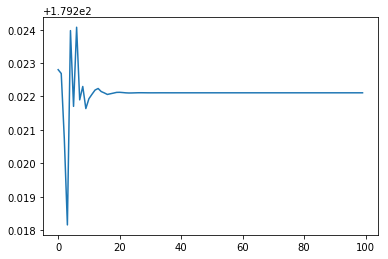

In [27]:
plt.plot(prediction_i[:,0])
plt.show()

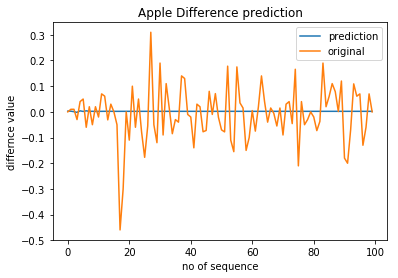

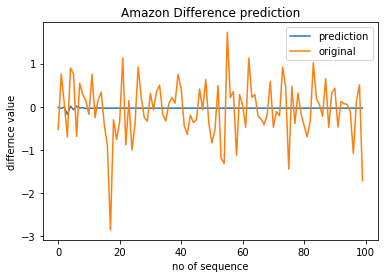

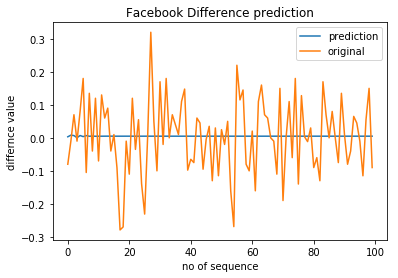

In [28]:
for i in range(len(dfs)):
    plt.plot(prediction[:,i:i+1],label="prediction")
    plt.plot(merge_test_output[:,i],label="original")
    plt.title(arr[i][:-4]+' Difference prediction')
    plt.xlabel('no of sequence')
    plt.ylabel('differnce value')
    plt.legend()
    plt.show()

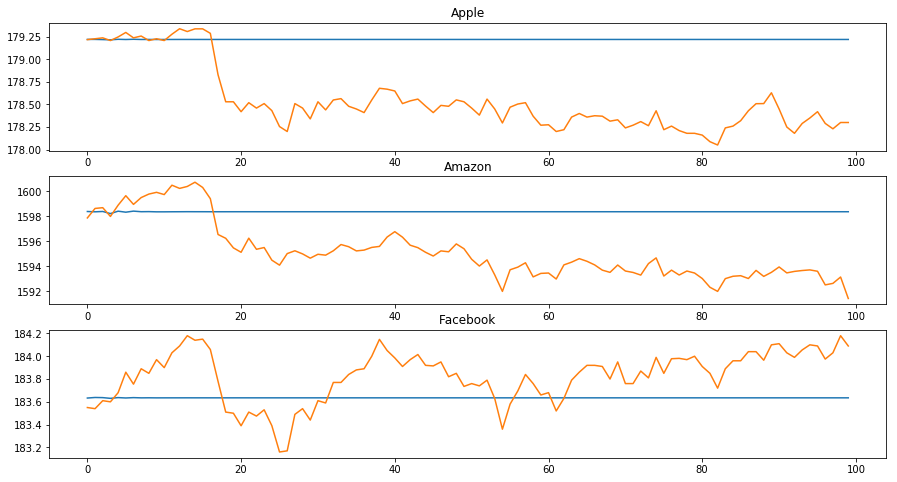

In [29]:
plt.figure(figsize=(15,8))
for i in range(len(dfs)):
    plt.subplot(3,1,i+1)
    plt.plot(prediction_i[:,i])
    plt.plot(result.iloc[:, [i]].iloc[-100:].values)
    plt.title(arr[i][:-4])
plt.show()

# Parallal Process

In [30]:
print(merge_train.shape, merge_train_output.shape)

(290, 12) (290, 3)


In [31]:
from keras.models import Model
from keras.layers import *

In [32]:
def fit_lstm(features,labels):
    
    dim_in = 4
    dim_out = 1
    nb_units = 6
    
    features = features.reshape(features.shape[0], 1, features.shape[1])   
    labels = labels.reshape(labels.shape[0], 1, labels.shape[1])   
    
    feature1, label1 = merge_train[:,0:4],merge_train_output[:,0:1]
    feature1 = feature1.reshape(feature1.shape[0], 1, feature1.shape[1])   
    label1 = label1.reshape(label1.shape[0], 1, label1.shape[1])
    
    feature2, label2 = merge_train[:,4:8],merge_train_output[:,1:2]
    feature2 = feature2.reshape(feature2.shape[0], 1, feature2.shape[1])   
    label2 = label2.reshape(label2.shape[0], 1, label2.shape[1])
    
    feature3, label3 = merge_train[:,8:12],merge_train_output[:,2:3]
    feature3 = feature3.reshape(feature3.shape[0], 1, feature3.shape[1])   
    label3 = label3.reshape(label3.shape[0], 1, label3.shape[1])
    
    
    #joining the models
    inp1 = Input((1,4))

    #two inputs for model 2 (the model we want to run twice as fast)
    inp2 = Input((1,4))
    inp3 = Input((1,4))
        
    model = Sequential()
    model.add(LSTM(batch_input_shape=(1, 1, 4),
                    return_sequences=True, 
                    units=6))
    model.add(Dropout(0.2))
    
    
    model.add(LSTM(4,return_sequences=True))
    model.add(Dropout(0.2))

    
    model.add(TimeDistributed(Dense(activation='selu', units=dim_out)))
    
    
    
    out1 = model(inp1)
    out2 = model(inp2)
    out3 = model(inp3)
    
    
    #out1 = model(feature1) #use model 2 once
    #out2 = model(feature2) 
    
    models = Model([inp1,inp2,inp3],[out1,out2,out3])
    
    #model.compile(loss = 'mse', optimizer = 'rmsprop')
    models.compile(loss='mean_squared_error', optimizer='adam')
    
    #model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False,callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')])

    
    
    for i in range(300):
        print("Completed :",i+1,"/",300, "Steps")
        #model.fit(features, labels, epochs=1, batch_size=1, verbose=0, shuffle=False)
        models.fit([feature1,feature2,feature3],[label1,label2,label3], epochs = 1,verbose=0,shuffle=False)
        models.reset_states()

    return models

In [33]:
print(merge_train[:,0:4].shape)
print(merge_train_output[:,0:1].shape)

(290, 4)
(290, 1)


In [34]:
models = fit_lstm(merge_train,merge_train_output)

Completed : 1 / 300 Steps
Completed : 2 / 300 Steps
Completed : 3 / 300 Steps
Completed : 4 / 300 Steps
Completed : 5 / 300 Steps
Completed : 6 / 300 Steps
Completed : 7 / 300 Steps
Completed : 8 / 300 Steps
Completed : 9 / 300 Steps
Completed : 10 / 300 Steps
Completed : 11 / 300 Steps
Completed : 12 / 300 Steps
Completed : 13 / 300 Steps
Completed : 14 / 300 Steps
Completed : 15 / 300 Steps
Completed : 16 / 300 Steps
Completed : 17 / 300 Steps
Completed : 18 / 300 Steps
Completed : 19 / 300 Steps
Completed : 20 / 300 Steps
Completed : 21 / 300 Steps
Completed : 22 / 300 Steps
Completed : 23 / 300 Steps
Completed : 24 / 300 Steps
Completed : 25 / 300 Steps
Completed : 26 / 300 Steps
Completed : 27 / 300 Steps
Completed : 28 / 300 Steps
Completed : 29 / 300 Steps
Completed : 30 / 300 Steps
Completed : 31 / 300 Steps
Completed : 32 / 300 Steps
Completed : 33 / 300 Steps
Completed : 34 / 300 Steps
Completed : 35 / 300 Steps
Completed : 36 / 300 Steps
Completed : 37 / 300 Steps
Completed 

In [35]:
input_data = np.copy(merge_train)
prediction = np.zeros((100,3))
prediction_i = np.zeros((100,3))
input_data = np.copy(merge_train[-1,:])


base_values = []


for i in range(len(dfs)):
    base_values.append(result.iloc[290][i])

for i in range(100):
    ts = []
    
    for m in range(len(dfs)):
        t = input_data[4*m + i : 4*(m+1) + i]
        t = t.reshape(1,1,4)
        
        ts.append(t)
    
    y = models.predict(ts)
    prediction[i] = np.concatenate(y, axis=1 ).reshape((1,1,len(dfs)))    
    for k in range(len(dfs)):
        input_data = np.insert(input_data,[i+4*(k+1)],y[k][0][0], axis=0)
        prediction_i[i][k] = base_values[k] + y[k][0][0]    
sqrt(mean_squared_error(merge_test_output, prediction))    

0.3927636063877299

In [36]:
prediction.shape

(100, 3)

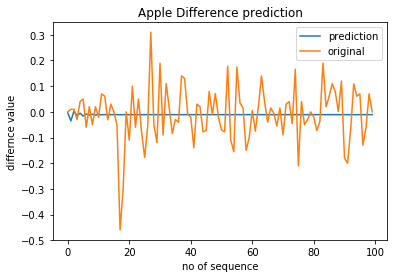

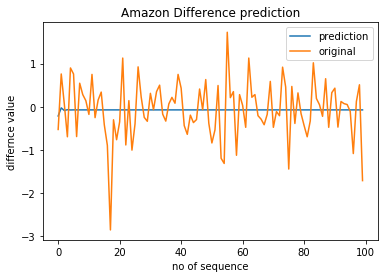

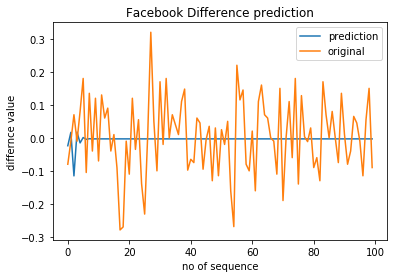

In [37]:
for i in range(len(dfs)):
    plt.plot(prediction[:,i:i+1],label="prediction")
    plt.plot(merge_test_output[:,i],label="original")
    plt.title(arr[i][:-4]+' Difference prediction')
    plt.xlabel('no of sequence')
    plt.ylabel('differnce value')
    plt.legend()
    plt.show()

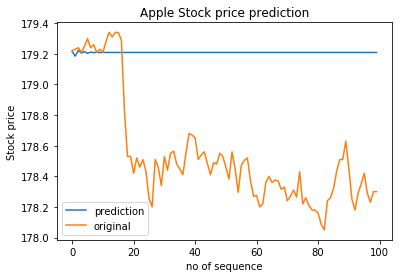

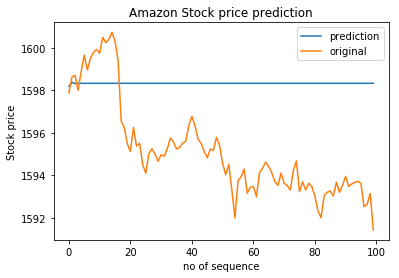

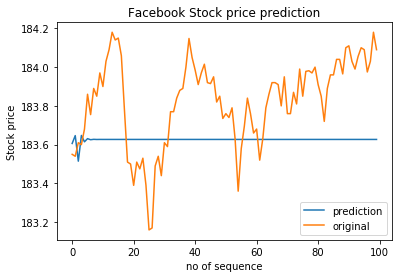

In [38]:
for i in range(len(dfs)):
    plt.plot(prediction_i[:,i:i+1],label="prediction")
    plt.plot(result.iloc[-100:,i].values,label="original")
    plt.title(arr[i][:-4]+' Stock price prediction')
    plt.xlabel('no of sequence')
    plt.ylabel('Stock price')
    plt.legend()
    plt.show()

# Using Indivisual company

In [39]:
import livelossplot
plot_losses = livelossplot.PlotLossesKeras()

def fit_lstm(features,labels):
    
    dim_in = 4
    dim_out = 1
    nb_units = 6
    
    model = Sequential()
    model.add(LSTM(batch_input_shape=(1, features.shape[1], features.shape[2]),return_sequences=True,units=10))
    model.add(Dropout(0.1))

    model.add(LSTM(units=4,return_sequences=False))
    model.add(Dropout(0.3))
    
    #model.add(TimeDistributed(Dense(units=1)))
    #model.add(Activation('linear'))
    
    model.add((Dense(activation='selu', units=1)))
    
    
    #model.compile(loss = 'mse', optimizer = 'rmsprop')
    model.compile(loss='mse', optimizer='rmsprop')
    
    #model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False,callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')])

    for i in range(300):
        #print("Completed :",i+1,"/",300, "Steps")
        #model.fit(features, labels, epochs=1, batch_size=1, verbose=0, shuffle=False)
        #model.fit(features,labels, epochs = 1,batch_size=1,verbose=0,shuffle=False,callbacks=[plot_losses])
        labels= labels.reshape((labels.shape[0], 1))
        model.fit(features,labels, epochs = 1, batch_size = 1,verbose=0)
        model.reset_states()
    print('Trained a model')
    return model

In [40]:
features_l = np.zeros((3,290,1,4))
labels_l = np.zeros((3,290,1,1))

In [41]:
for i in range(len(dfs)):
    features_l[i],labels_l[i] = merge_train[:,i*4:4 + 4* i].reshape(290,1,4),merge_train_output[:,i:i+1].reshape(290,1,1)

In [42]:
print(features_l.shape)
print(labels_l.shape)

(3, 290, 1, 4)
(3, 290, 1, 1)


In [43]:
#feature1 = feature1.reshape(feature1.shape[0], 1, feature1.shape[1])   
#label1 = label1.reshape(label1.shape[0], 1, label1.shape[1])

In [44]:
#feature1, label1 = merge_train[:,8:12],merge_train_output[:,2:3]
#feature1 = feature1.reshape(feature1.shape[0], 1, feature1.shape[1])   
#label1 = label1.reshape(label1.shape[0], 1, label1.shape[1])

In [45]:
prediction_diff = np.zeros((3,100))
prediction_stock = np.zeros((3,100))

for k in range(len(dfs)):
    model = fit_lstm(features_l[k],labels_l[k])
    
    
    base_value = result.iloc[291,k]
    #prediction_apple = []
    #orig_pred = []
    input_data = np.copy(merge_test[0,4*k:4*k + 4])
    input_data = input_data.reshape(len(input_data),1) 


    for i in range(100):
        inp = input_data[i:,:]
        inp = inp.reshape(1,1,inp.shape[0])

        y = model.predict(inp)

        prediction_diff[k][i] = y[0][0]
        input_data = np.insert(input_data,[i+4],y[0][0], axis=0)
        base_value = base_value  + y
        prediction_stock[k][i] = base_value[0][0]



    print(arr[k][:-4]," Stock Rmse error :",sqrt(mean_squared_error(merge_test_output[:,k:k+1], prediction_diff[k])))

Trained a model
Apple  Stock Rmse error : 0.10730258910781341
Trained a model
Amazon  Stock Rmse error : 0.6703268912509561
Trained a model
Facebook  Stock Rmse error : 0.11219750496534907


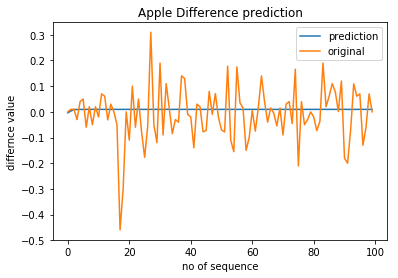

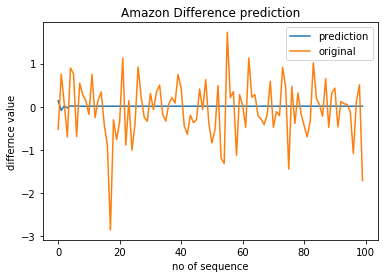

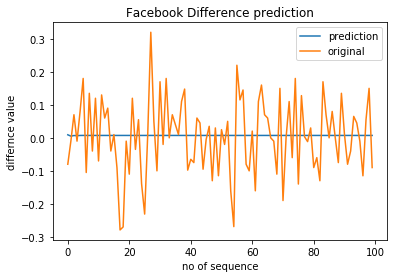

In [46]:
for i in range(len(dfs)):
    plt.plot(prediction_diff[i,:],label="prediction")
    plt.plot(merge_test_output[:,i],label="original")
    plt.title(arr[i][:-4]+' Difference prediction')
    plt.xlabel('no of sequence')
    plt.ylabel('differnce value')
    plt.legend()
    plt.show()

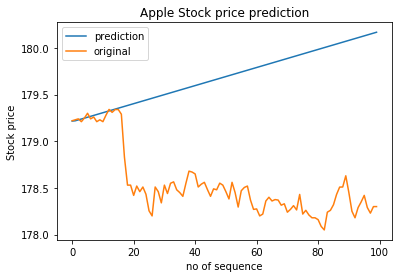

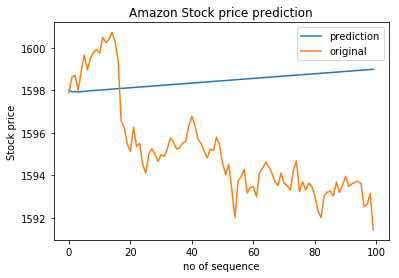

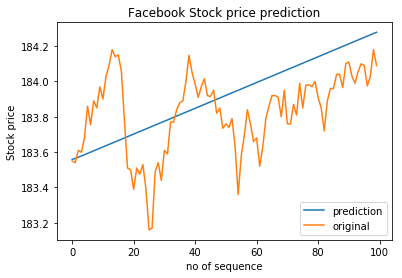

In [47]:
for i in range(len(dfs)):
    plt.plot(prediction_stock[i,:],label="prediction")
    plt.plot(result.iloc[-100:,i].values,label="original")
    plt.title(arr[i][:-4]+' Stock price prediction')
    plt.xlabel('no of sequence')
    plt.ylabel('Stock price')
    plt.legend()
    plt.show()